# Assignment 1 - Implementation and application of online power PCA

## Preamble
### Power PCA

In Lecture 4 we learned about the power method for PCA, which is based on the following iterative process
$$\mathbf{w}\leftarrow \mathbf{Rw}, \mathbf{w}\leftarrow\frac{\mathbf{w}}{\|\mathbf{w}\|}$$
that makes $\mathbf{w}$ converge to the (first) eigenvector. 
After obtaining the first eigenvector, the R matrix needs to be deflated:
$$ \mathbf{R} \leftarrow \mathbf{R} - \mathbf{ww}^T\mathbf{R}$$
With progressive deflation of $\mathbf{R}$, multiple eigenvectors can be worked out using the same process.

### Dataset
For this assignment we are using an image dataset Fashion-MNIST. This dataset is being promoted as a new benchmark (instead of MNIST) for a number of machine learning problems. We will work on a partial version of the dataset,  downloadable as a text file, "fashion-mnist_test.csv". It contains 10,000 rows of data, each row started with a class label ('0'-'9'), and followed by 784 (28x28) pixel values in grayscale. 

## Part 1. Visualization

**Task 1**. Use Pandas' utilities to load in the CSV file. Assign data and labels to different arrays. Plot out a few rows of data by showing them as 28x28 grayscale images. (1 mark)

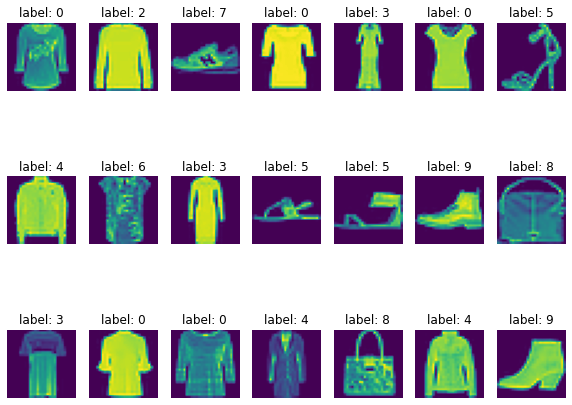

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fashion_mnist_data = pd.read_csv("fashion-mnist_test.csv")

# %%
fig, axs = plt.subplots(3, 7, figsize = (10,8))
# i = 0
for col in range(7):
    for row in range(3):
        ax = axs[row, col]
        sample_data = fashion_mnist_data.sample(1)
        title = sample_data.iloc[0, 0]
        single_picture = sample_data.iloc[0, 1:].values.reshape(28, 28)
        ax.imshow(single_picture)
        ax.set_title(f"label: {title}")
        ax.axis("off")

*For sake of efficiency you can subsample the data by 50% and use it for the following tasks.*

**Task 2**. Implement the power method and work out the first two eigenvectors using the dataset. Plot out a 2-D scatterplot of the projected data using the powerPCA() function. (3 marks)


Use different markers to differentiate data points of different classes. 

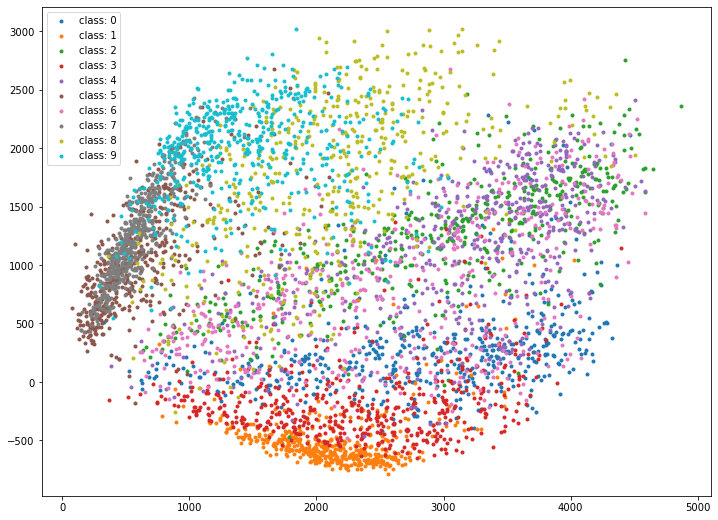

In [23]:
# %%
# 幂迭代法
# %%
small_data = fashion_mnist_data.sample(5000)
small_x = small_data.iloc[:, 1:]
small_label = small_data.iloc[:, 0]


# 计算协方差
small_x_cov = small_x.cov()
# 求small_x_cov前两个的特征值和特征向量


def powerPCA(matrix):

    def power_iteration(A, num_simulations=100):
        # Ideally choose a random vector
        # To decrease the chance that our vector
        # Is orthogonal to the eigenvector
        b_k = np.random.rand(A.shape[1])

        for _ in range(num_simulations):
            # calculate the matrix-by-vector product Ab
            b_k1 = np.dot(A, b_k)

            # calculate the norm
            b_k1_norm = np.linalg.norm(b_k1)

            # re normalize the vector
            b_k = b_k1 / b_k1_norm

        return b_k

    A = matrix
    eig_vector_1 = power_iteration(A=A).reshape(1, -1)  # 第一个特征向量
    eig_value_1 = np.dot(eig_vector_1, np.dot(
        A, eig_vector_1.T))  # 第一个特征值

    # 创建一个新的矩阵
    B = A - eig_value_1 / \
        np.linalg.norm(eig_vector_1) ** 2 * \
        np.dot(eig_vector_1.T, eig_vector_1)
    eig_vector_2 = power_iteration(A=B)
    eig_value_2 = np.dot(eig_vector_2, np.dot(B, eig_vector_2.T))  # 第二个特征值
    eig_vector_2 = eig_vector_2.reshape(1, -1)  # 第二个特征向量

    top_2_eig_vector = np.vstack((eig_vector_1, eig_vector_2)).T

    return [eig_value_1, eig_value_2], top_2_eig_vector


eig_value_2, eig_vector_2 = powerPCA(small_x_cov)
# %%
top_2_dim_data = np.matmul(small_x.values, eig_vector_2)

#%%
fig, ax = plt.subplots(figsize=(12, 9))
for i in range(10):
    temp_plot_data = top_2_dim_data[small_label == i, :]
    ax.scatter(temp_plot_data[:, 0], temp_plot_data[:,1], marker='.', label=f"class: {i}")
plt.legend()

## Part 2. Online PCA using modified power method

The $\mathtt{powerPCA}$ method given above carries out PCA in a batch mode, i.e., it needs to gather all data to compute the covariance matrix $\mathbf{R}$, and then the power iterations follow (along with the deflation of $\mathbf{R}$ for each eigenvector obtained). 

The following is an idea about developing an incremental Power method for online analysis of data streams. 

First, use a mini-batch, say the first 100 rows of $\mathbf{X}$ to obtain the mean vector $\mathbf{m}$, and the covariance matrix $\mathbf{R}$ in the same way as in the $\mathtt{powerPCA()}$ method. Now, design an online Power Method algorithm that carries out the following operations:
1. Use the next row of $\mathbf{X}$ as input $\mathbf{x}$, and update the online average $\mathbf{m}$.
2. Use $\mathbf{x}$ to update $\mathbf{R}$ (as an online average of $\mathbf{x}^T\mathbf{x})$.
3. Write an $\mathtt{onlinePowerPCA(R)}$ method that derives the eigenvectors and eigenvalues of
the updated $\mathbf{R}$, using the current eigenvector as the initial $\mathbf{w}$.
4. Repeat the above process until all entries of $\mathbf{X}$ are handled.

Following the idea we introduced in online clustering, we can use the exponential weighting to produce the online average, e.g.
$$\mathbf{m}\leftarrow \mathbf{m}+ \gamma(\mathbf{x}-\mathbf{m})=(1-\gamma)\mathbf{m}+\gamma\mathbf{x}$$
where $\gamma$ is a weighting coefficient, $0<\gamma\ll 1$. The same idea works for updating $\mathbf{R}$ as well. 

**Task 3**. Use $\mathtt{onlinePowerPCA()}$ to visualize the dataset, generating PCA snapshots of the dataset upon processing every 500 data points. Compare the final visualization with that of Task 2. (2 marks)

*Comments:* 

## Part 3. Incremental Power PCA for anomaly detection

Online PCA can be used as an effective tool for stream data outlier detection. Our following
adventure is based on an idea from an article entitled "Anomaly detection via online oversampling principal
component analysis", by Lee et al., in TKDE 25:7.

To start, randomly extract 100 data instances that belong to the "0" class and construct the initial $\mathtt{R}$ matrix.
Carry out batch power PCA and obtain the first eigenvector $\mathtt{e}$.

What follows is we will take a new data point x, and use it to calculate a new covariance matrix
$\mathtt{R1}$ based on $\mathtt{R}$. After obtaining its first eigenvector, denoted by $\mathtt{e1}$, we correlate it with the original eigenvector $\mathtt{e}$. It is expected that a "0" class data point will produce an eigenvector
strongly correlated to $\mathtt{e}$ (with correlation close to 1), while data points of other classes will produce significant deviations (i.e. with correlation close to 0). Hence we can use  a threshold to *test* on each data point and decide whether it is an *anomaly*.  

Note you'll need to keep a copy of the old $\mathtt{R}$ as it is needed for each test. 

To evaluate this outlier detection scheme, we iterate through the dataset:
1. Pick the next data point $\mathtt{x}$.
2. Call $\mathtt{onlinePowerPCA()}$ and obtain the first eigenvector $\mathtt{e1}$.
3. Calculate the correlation between the old and new eigenvectors $\mathtt{e}$ and $\mathtt{e1}$: $\mathtt{corr=e.T*e1}$.
4. Use a threshold on 'corr' so as to decide whether the current input is an outlier.
5. Compare the result with the class labels ($\mathtt{y}$) and collect error statistics such as true positive rate (TPR) and false positive rate (FPR).

**Task 4**. Implement the anomaly detection algorithm. Experiment with different different $\gamma$ and threshold values in the algorithm, and recommend a good parameter setting. (3 marks)

**Task 5**. Summarize your findings in the report. (1 mark)

Your comments:

- 